# Chapter 16: Safety and Robustness in Reinforcement Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/ReinforcementLearning/blob/main/notebooks/chapter16_safety_robustness.ipynb)

## Introduction

As RL systems are deployed in safety-critical applications, ensuring their safety and robustness becomes paramount. This chapter covers techniques for safe exploration, constraint satisfaction, robustness to distribution shift, and verification of RL policies.

### Key Topics Covered:
- Safe Reinforcement Learning and Constrained MDPs
- Safe Exploration Techniques
- Robust RL and Adversarial Training
- Distributional Shift and Domain Adaptation
- Verification and Interpretability
- Risk-Aware Decision Making

## Mathematical Foundation

### Constrained Markov Decision Process (CMDP)

A CMDP extends the standard MDP with constraints:
$$\max_{\pi} \mathbb{E}_{\pi}\left[\sum_{t=0}^\infty \gamma^t r_t\right]$$
$$\text{s.t. } \mathbb{E}_{\pi}\left[\sum_{t=0}^\infty \gamma^t c_i(s_t, a_t)\right] \leq d_i, \quad \forall i$$

where $c_i$ are cost functions and $d_i$ are constraint thresholds.

### Risk Measures

**Conditional Value at Risk (CVaR)**:
$$\text{CVaR}_\alpha(X) = \mathbb{E}[X | X \geq \text{VaR}_\alpha(X)]$$

**Coherent Risk Measures** satisfy:
- Monotonicity: $X \leq Y \Rightarrow \rho(X) \geq \rho(Y)$
- Translation equivariance: $\rho(X + c) = \rho(X) - c$
- Convexity: $\rho(\lambda X + (1-\lambda)Y) \leq \lambda\rho(X) + (1-\lambda)\rho(Y)$
- Positive homogeneity: $\rho(\lambda X) = \lambda\rho(X)$ for $\lambda > 0$

### Robust MDP

In robust MDPs, we optimize against the worst-case environment:
$$\max_{\pi} \min_{P \in \mathcal{P}} \mathbb{E}_{\pi,P}\left[\sum_{t=0}^\infty \gamma^t r_t\right]$$

where $\mathcal{P}$ is an uncertainty set of transition probabilities.

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import random
from typing import List, Tuple, Dict, Optional, Callable
import copy
from scipy import stats

# Try to import PyTorch for neural network implementations
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.distributions import Categorical, Normal
    HAS_TORCH = True
    print("PyTorch available - using neural network implementations")
except ImportError:
    HAS_TORCH = False
    print("PyTorch not available - using analytical implementations")

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
if HAS_TORCH:
    torch.manual_seed(42)

PyTorch available - using neural network implementations


## Safety-Critical Environments

We'll create environments that demonstrate safety challenges in RL.

In [7]:
class SafeNavigationEnvironment:
    """Navigation environment with safety constraints (obstacles and hazards)."""

    def __init__(self, grid_size=8, n_obstacles=3, n_hazards=2):
        self.grid_size = grid_size
        self.n_obstacles = n_obstacles
        self.n_hazards = n_hazards

        # Actions: up, down, left, right
        self.action_space = 4
        self.action_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        self.setup_environment()
        self.reset()

    def setup_environment(self):
        """Setup obstacles, hazards, and goal."""
        # Initialize grid (0 = free, 1 = obstacle, 2 = hazard, 3 = goal)
        self.grid = np.zeros((self.grid_size, self.grid_size))

        # Place obstacles (impassable)
        self.obstacles = []
        for _ in range(self.n_obstacles):
            while True:
                pos = (np.random.randint(1, self.grid_size-1), np.random.randint(1, self.grid_size-1))
                if self.grid[pos] == 0:
                    self.grid[pos] = 1
                    self.obstacles.append(pos)
                    break

        # Place hazards (passable but dangerous)
        self.hazards = []
        for _ in range(self.n_hazards):
            while True:
                pos = (np.random.randint(1, self.grid_size-1), np.random.randint(1, self.grid_size-1))
                if self.grid[pos] == 0:
                    self.grid[pos] = 2
                    self.hazards.append(pos)
                    break

        # Place goal
        self.goal_pos = (self.grid_size-1, self.grid_size-1)
        self.grid[self.goal_pos] = 3

        # Start position
        self.start_pos = (0, 0)

    def reset(self):
        """Reset environment."""
        self.agent_pos = self.start_pos
        self.episode_steps = 0
        self.max_steps = self.grid_size * 3
        self.total_cost = 0
        self.safety_violations = 0

        return self.get_state()

    def get_state(self):
        """Get current state."""
        # State includes agent position and goal position
        return np.array([self.agent_pos[0], self.agent_pos[1],
                        self.goal_pos[0], self.goal_pos[1]])

    def step(self, action):
        """Execute action."""
        old_pos = self.agent_pos
        delta = self.action_map[action]
        new_pos = (old_pos[0] + delta[0], old_pos[1] + delta[1])

        # Check bounds
        if (new_pos[0] < 0 or new_pos[0] >= self.grid_size or
            new_pos[1] < 0 or new_pos[1] >= self.grid_size):
            new_pos = old_pos

        # Check obstacles
        if new_pos in self.obstacles:
            new_pos = old_pos

        self.agent_pos = new_pos
        self.episode_steps += 1

        # Calculate reward and cost
        reward = -1  # Step penalty
        cost = 0

        if self.agent_pos == self.goal_pos:
            reward += 100
            done = True
        elif self.agent_pos in self.hazards:
            cost = 10  # Safety cost
            reward -= 50  # Penalty for entering hazard
            self.safety_violations += 1
            done = False
        else:
            done = self.episode_steps >= self.max_steps

        self.total_cost += cost

        info = {
            'cost': cost,
            'total_cost': self.total_cost,
            'safety_violations': self.safety_violations,
            'distance_to_goal': abs(self.agent_pos[0] - self.goal_pos[0]) +
                               abs(self.agent_pos[1] - self.goal_pos[1])
        }

        return self.get_state(), reward, done, info

    def render(self):
        """Visualize environment."""
        vis_grid = self.grid.copy()
        vis_grid[self.agent_pos] = 4  # Agent
        return vis_grid

class RiskyBanditEnvironment:
    """Multi-armed bandit with risk considerations."""

    def __init__(self, n_arms=3, risk_level=0.1):
        self.n_arms = n_arms
        self.risk_level = risk_level

        # Arm characteristics: (mean_reward, std_reward, failure_prob, failure_cost)
        self.arms = [
            (0.5, 0.1, 0.05, -10),  # Safe arm: low reward, low risk
            (1.0, 0.3, 0.1, -20),   # Medium arm: medium reward, medium risk
            (1.5, 0.5, 0.2, -50)    # Risky arm: high reward, high risk
        ]

        self.episode_steps = 0
        self.total_failures = 0
        self.total_cost = 0

    def reset(self):
        """Reset environment."""
        self.episode_steps = 0
        self.total_failures = 0
        self.total_cost = 0
        return None

    def step(self, action):
        """Execute action."""
        if action < 0 or action >= self.n_arms:
            return 0, {'cost': 0, 'failure': False}

        mean_reward, std_reward, failure_prob, failure_cost = self.arms[action]

        # Sample base reward
        reward = np.random.normal(mean_reward, std_reward)

        # Check for failure
        failure = np.random.random() < failure_prob
        cost = 0

        if failure:
            cost = -failure_cost  # Positive cost
            reward += failure_cost  # Negative reward component
            self.total_failures += 1

        self.total_cost += cost
        self.episode_steps += 1

        info = {
            'cost': cost,
            'total_cost': self.total_cost,
            'failure': failure,
            'total_failures': self.total_failures,
            'arm_risk': failure_prob
        }

        return reward, info

# Test safety environments
safe_nav = SafeNavigationEnvironment()
risky_bandit = RiskyBanditEnvironment()

print(f"Safe Navigation: {safe_nav.grid_size}x{safe_nav.grid_size} grid")
print(f"Obstacles at: {safe_nav.obstacles}")
print(f"Hazards at: {safe_nav.hazards}")
print(f"Goal at: {safe_nav.goal_pos}")

print(f"\nRisky Bandit: {risky_bandit.n_arms} arms")
for i, (mean, std, fail_prob, fail_cost) in enumerate(risky_bandit.arms):
    print(f"  Arm {i}: μ={mean:.1f}, σ={std:.1f}, fail_prob={fail_prob:.2f}, fail_cost={fail_cost}")

# Test environments
nav_state = safe_nav.reset()
bandit_state = risky_bandit.reset()

print(f"\nNavigation initial state: {nav_state}")
print(f"Navigation grid visualization:")
print(safe_nav.render())

Safe Navigation: 8x8 grid
Obstacles at: [(4, 5), (3, 5), (5, 2)]
Hazards at: [(3, 3), (4, 3)]
Goal at: (7, 7)

Risky Bandit: 3 arms
  Arm 0: μ=0.5, σ=0.1, fail_prob=0.05, fail_cost=-10
  Arm 1: μ=1.0, σ=0.3, fail_prob=0.10, fail_cost=-20
  Arm 2: μ=1.5, σ=0.5, fail_prob=0.20, fail_cost=-50

Navigation initial state: [0 0 7 7]
Navigation grid visualization:
[[4. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 1. 0. 0.]
 [0. 0. 0. 2. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3.]]


## Safe Reinforcement Learning with Constraints

We'll implement Constrained Policy Optimization (CPO) and safe exploration techniques.

In [8]:
class SafePolicyGradient:
    """Safe policy gradient with cost constraints."""

    def __init__(self, state_dim, action_dim, cost_limit=10, lr=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.cost_limit = cost_limit
        self.lr = lr

        # Simple tabular policy for discrete environments
        self.policy_params = np.random.randn(state_dim, action_dim) * 0.1
        self.value_params = np.random.randn(state_dim + 1) * 0.1
        self.cost_value_params = np.random.randn(state_dim + 1) * 0.1

        # Lagrange multiplier for cost constraint
        self.lambda_cost = 0.1

        # Statistics
        self.episode_rewards = []
        self.episode_costs = []
        self.constraint_violations = []
        self.lambda_history = []

    def get_policy(self, state_hash):
        """Get action probabilities for state."""
        # Simple hash-based state representation
        state_idx = state_hash % self.state_dim
        logits = self.policy_params[state_idx]
        probs = np.exp(logits) / np.sum(np.exp(logits))
        return probs

    def get_action(self, state_hash):
        """Sample action from policy."""
        probs = self.get_policy(state_hash)
        return np.random.choice(len(probs), p=probs)

    def get_value(self, state_hash, cost=False):
        """Get state value estimate."""
        state_idx = state_hash % self.state_dim
        features = np.zeros(self.state_dim + 1)
        features[state_idx] = 1.0
        features[-1] = 1.0  # Bias term

        if cost:
            return np.dot(features, self.cost_value_params)
        else:
            return np.dot(features, self.value_params)

    def hash_state(self, state):
        """Simple state hashing for discrete representation."""
        if isinstance(state, np.ndarray):
            return hash(tuple(state.astype(int)))
        return hash(state)

    def train_episode(self, env, max_steps=50):
        """Train on one episode with safety constraints."""
        trajectory = []
        state = env.reset()
        episode_reward = 0
        episode_cost = 0

        for step in range(max_steps):
            state_hash = self.hash_state(state)
            action = self.get_action(state_hash)

            if hasattr(env, 'step'):  # Navigation environment
                next_state, reward, done, info = env.step(action)
                cost = info.get('cost', 0)
            else:  # Bandit environment
                reward, info = env.step(action)
                cost = info.get('cost', 0)
                next_state = None
                done = step >= max_steps - 1

            trajectory.append((state_hash, action, reward, cost, done))
            episode_reward += reward
            episode_cost += cost

            if done:
                break

            state = next_state

        # Update policy with safety constraints
        self.update_policy(trajectory)

        # Update Lagrange multiplier
        constraint_violation = max(0, episode_cost - self.cost_limit)
        self.lambda_cost = max(0, self.lambda_cost + 0.01 * constraint_violation)

        # Store statistics
        self.episode_rewards.append(episode_reward)
        self.episode_costs.append(episode_cost)
        self.constraint_violations.append(constraint_violation)
        self.lambda_history.append(self.lambda_cost)

        return episode_reward, episode_cost

    def update_policy(self, trajectory):
        """Update policy using constrained policy gradient."""
        # Compute returns and advantages
        returns = []
        cost_returns = []
        G_reward = 0
        G_cost = 0

        for state_hash, action, reward, cost, done in reversed(trajectory):
            G_reward = reward + 0.99 * G_reward
            G_cost = cost + 0.99 * G_cost
            returns.insert(0, G_reward)
            cost_returns.insert(0, G_cost)

        # Policy gradient update with cost constraint
        for i, (state_hash, action, reward, cost, done) in enumerate(trajectory):
            state_idx = state_hash % self.state_dim

            # Compute advantages
            value = self.get_value(state_hash, cost=False)
            cost_value = self.get_value(state_hash, cost=True)

            advantage = returns[i] - value
            cost_advantage = cost_returns[i] - cost_value

            # Safe policy gradient update
            probs = self.get_policy(state_hash)

            # Gradient of log policy
            grad_log_pi = np.zeros(self.action_dim)
            grad_log_pi[action] = 1.0 - probs[action]
            for a in range(self.action_dim):
                if a != action:
                    grad_log_pi[a] = -probs[a]

            # Constrained update: maximize reward - lambda * cost
            policy_gradient = advantage * grad_log_pi - self.lambda_cost * cost_advantage * grad_log_pi

            self.policy_params[state_idx] += self.lr * policy_gradient

            # Update value functions
            features = np.zeros(self.state_dim + 1)
            features[state_idx] = 1.0
            features[-1] = 1.0

            # Value function updates
            value_error = returns[i] - value
            cost_value_error = cost_returns[i] - cost_value

            self.value_params += 0.1 * value_error * features
            self.cost_value_params += 0.1 * cost_value_error * features

class SafeExploration:
    """Safe exploration using optimistic initialization and confidence bounds."""

    def __init__(self, state_space_size, action_space_size, safety_threshold=0.1):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.safety_threshold = safety_threshold

        # Initialize optimistically (assume actions are safe)
        self.safety_estimates = np.ones((state_space_size, action_space_size)) * 0.01
        self.safety_counts = np.ones((state_space_size, action_space_size))
        self.safety_confidence = np.ones((state_space_size, action_space_size))

        # Q-values with safety constraints
        self.Q = np.random.randn(state_space_size, action_space_size) * 0.1
        self.visit_counts = np.ones((state_space_size, action_space_size))

        self.episode_rewards = []
        self.safety_violations = []

    def get_safe_actions(self, state):
        """Get actions that are deemed safe with high confidence."""
        state_idx = state % self.state_space_size

        # Compute confidence bounds for safety
        confidence_radius = np.sqrt(2 * np.log(np.sum(self.safety_counts[state_idx])) /
                                   self.safety_counts[state_idx])

        upper_safety_bounds = self.safety_estimates[state_idx] + confidence_radius

        # Actions are safe if upper bound is below threshold
        safe_actions = np.where(upper_safety_bounds < self.safety_threshold)[0]

        return safe_actions if len(safe_actions) > 0 else [0]  # Fallback to action 0

    def select_action(self, state, epsilon=0.1):
        """Select action using safe exploration."""
        state_idx = state % self.state_space_size
        safe_actions = self.get_safe_actions(state)

        if np.random.random() < epsilon:
            # Explore among safe actions
            return np.random.choice(safe_actions)
        else:
            # Exploit best safe action
            safe_q_values = self.Q[state_idx, safe_actions]
            best_safe_idx = np.argmax(safe_q_values)
            return safe_actions[best_safe_idx]

    def update(self, state, action, reward, cost, next_state):
        """Update Q-values and safety estimates."""
        state_idx = state % self.state_space_size
        next_state_idx = next_state % self.state_space_size if next_state is not None else 0

        # Update Q-values
        alpha = 1.0 / self.visit_counts[state_idx, action]

        if next_state is not None:
            safe_next_actions = self.get_safe_actions(next_state)
            next_q_max = np.max(self.Q[next_state_idx, safe_next_actions])
            target = reward + 0.99 * next_q_max
        else:
            target = reward

        self.Q[state_idx, action] += alpha * (target - self.Q[state_idx, action])

        # Update safety estimates
        safety_alpha = 1.0 / self.safety_counts[state_idx, action]
        unsafe_indicator = 1.0 if cost > 0 else 0.0

        self.safety_estimates[state_idx, action] += safety_alpha * (
            unsafe_indicator - self.safety_estimates[state_idx, action]
        )

        # Update counts
        self.visit_counts[state_idx, action] += 1
        self.safety_counts[state_idx, action] += 1

    def train_episode(self, env, max_steps=50):
        """Train episode with safe exploration."""
        state = env.reset()
        episode_reward = 0
        episode_violations = 0

        for step in range(max_steps):
            state_hash = hash(tuple(state.astype(int))) if isinstance(state, np.ndarray) else hash(state)
            action = self.select_action(state_hash)

            if hasattr(env, 'step'):  # Navigation environment
                next_state, reward, done, info = env.step(action)
                cost = info.get('cost', 0)
                next_state_hash = hash(tuple(next_state.astype(int))) if isinstance(next_state, np.ndarray) else None
            else:  # Bandit environment
                reward, info = env.step(action)
                cost = info.get('cost', 0)
                next_state_hash = None
                done = step >= max_steps - 1

            if cost > 0:
                episode_violations += 1

            self.update(state_hash, action, reward, cost, next_state_hash)
            episode_reward += reward

            if done:
                break

            state = next_state if hasattr(env, 'step') else state

        self.episode_rewards.append(episode_reward)
        self.safety_violations.append(episode_violations)

        return episode_reward, episode_violations

# Train safe RL agents
safe_nav = SafeNavigationEnvironment()

# Safe policy gradient
safe_pg = SafePolicyGradient(state_dim=16, action_dim=4, cost_limit=5)

print("Training safe policy gradient...")
for episode in range(100):
    reward, cost = safe_pg.train_episode(safe_nav)

    if episode % 20 == 0:
        avg_reward = np.mean(safe_pg.episode_rewards[-10:])
        avg_cost = np.mean(safe_pg.episode_costs[-10:])
        avg_violations = np.mean(safe_pg.constraint_violations[-10:])
        print(f"Episode {episode}: Reward={avg_reward:.1f}, Cost={avg_cost:.1f}, Violations={avg_violations:.1f}")

# Safe exploration
safe_explorer = SafeExploration(state_space_size=64, action_space_size=4)

print("\nTraining safe exploration agent...")
for episode in range(100):
    reward, violations = safe_explorer.train_episode(safe_nav)

    if episode % 20 == 0:
        avg_reward = np.mean(safe_explorer.episode_rewards[-10:])
        avg_violations = np.mean(safe_explorer.safety_violations[-10:])
        print(f"Episode {episode}: Reward={avg_reward:.1f}, Safety Violations={avg_violations:.1f}")

print("Safe RL training completed")

Training safe policy gradient...
Episode 0: Reward=-24.0, Cost=0.0, Violations=0.0
Episode 20: Reward=-49.0, Cost=5.0, Violations=4.0
Episode 40: Reward=-24.0, Cost=0.0, Violations=0.0
Episode 60: Reward=-24.0, Cost=0.0, Violations=0.0
Episode 80: Reward=-24.0, Cost=0.0, Violations=0.0

Training safe exploration agent...
Episode 0: Reward=-24.0, Safety Violations=0.0
Episode 20: Reward=-24.0, Safety Violations=0.0
Episode 40: Reward=-24.0, Safety Violations=0.0
Episode 60: Reward=-24.0, Safety Violations=0.0
Episode 80: Reward=-24.0, Safety Violations=0.0
Safe RL training completed


## Robust Reinforcement Learning

Robust RL techniques handle uncertainty and adversarial perturbations.

In [9]:
class RobustBanditAgent:
    """Robust multi-armed bandit using distributionally robust optimization."""

    def __init__(self, n_arms, confidence_level=0.1, robust_radius=0.1):
        self.n_arms = n_arms
        self.confidence_level = confidence_level
        self.robust_radius = robust_radius

        # Empirical estimates
        self.arm_rewards = [[] for _ in range(n_arms)]
        self.arm_costs = [[] for _ in range(n_arms)]

        # Robust estimates
        self.robust_mean_rewards = np.zeros(n_arms)
        self.robust_std_rewards = np.ones(n_arms)
        self.robust_mean_costs = np.zeros(n_arms)

        self.episode_rewards = []
        self.episode_costs = []
        self.episode_regrets = []

    def compute_robust_bounds(self, arm):
        """Compute robust confidence bounds for an arm."""
        if len(self.arm_rewards[arm]) == 0:
            return 0, float('inf'), 0  # Optimistic initialization

        rewards = np.array(self.arm_rewards[arm])
        costs = np.array(self.arm_costs[arm])

        n = len(rewards)

        # Empirical mean and std
        emp_mean_reward = np.mean(rewards)
        emp_std_reward = np.std(rewards) + 1e-6
        emp_mean_cost = np.mean(costs)

        # Robust bounds using concentration inequalities
        confidence_radius = np.sqrt(2 * np.log(1/self.confidence_level) / n)

        # Worst-case mean (for robust optimization)
        robust_lower_reward = emp_mean_reward - confidence_radius - self.robust_radius * emp_std_reward
        robust_upper_cost = emp_mean_cost + confidence_radius + self.robust_radius * np.std(costs + 1e-6)

        return robust_lower_reward, robust_upper_cost, confidence_radius

    def select_robust_action(self, risk_aversion=1.0):
        """Select action using robust optimization."""
        if np.random.random() < 0.1:  # Exploration
            return np.random.randint(0, self.n_arms)

        robust_utilities = []

        for arm in range(self.n_arms):
            robust_reward, robust_cost, confidence = self.compute_robust_bounds(arm)

            # Robust utility: worst-case reward minus risk-adjusted cost
            robust_utility = robust_reward - risk_aversion * robust_cost
            robust_utilities.append(robust_utility)

        return np.argmax(robust_utilities)

    def update(self, arm, reward, cost):
        """Update estimates with new observation."""
        self.arm_rewards[arm].append(reward)
        self.arm_costs[arm].append(cost)

        # Update robust estimates
        robust_reward, robust_cost, _ = self.compute_robust_bounds(arm)
        self.robust_mean_rewards[arm] = robust_reward
        self.robust_mean_costs[arm] = robust_cost

    def train_episode(self, env, n_steps=50):
        """Train episode with robust decision making."""
        env.reset()
        episode_reward = 0
        episode_cost = 0

        for step in range(n_steps):
            action = self.select_robust_action(risk_aversion=0.5)
            reward, info = env.step(action)
            cost = info.get('cost', 0)

            self.update(action, reward, cost)
            episode_reward += reward
            episode_cost += cost

        self.episode_rewards.append(episode_reward)
        self.episode_costs.append(episode_cost)

        return episode_reward, episode_cost

class AdversarialEnvironment:
    """Environment with adversarial perturbations."""

    def __init__(self, base_env, perturbation_strength=0.1):
        self.base_env = base_env
        self.perturbation_strength = perturbation_strength
        self.adversarial_mode = False

    def reset(self):
        return self.base_env.reset()

    def step(self, action):
        """Step with potential adversarial perturbations."""
        # Check if the base environment returns a state tuple or just reward and info
        if isinstance(self.base_env, SafeNavigationEnvironment):
            state, reward, done, info = self.base_env.step(action)
        else:
            reward, info = self.base_env.step(action)
            state, done = None, False

        # Apply adversarial perturbations
        if self.adversarial_mode:
            # Perturb reward (worst-case)
            reward_perturbation = -self.perturbation_strength * abs(reward)
            reward += reward_perturbation

            # Increase costs
            if 'cost' in info:
                cost_perturbation = self.perturbation_strength * 10
                info['cost'] += cost_perturbation

        if isinstance(self.base_env, SafeNavigationEnvironment):
            return state, reward, done, info
        else:
            return reward, info

    def enable_adversary(self):
        """Enable adversarial perturbations."""
        self.adversarial_mode = True

    def disable_adversary(self):
        """Disable adversarial perturbations."""
        self.adversarial_mode = False

class RiskAwareBandit:
    """Risk-aware bandit using CVaR optimization."""

    def __init__(self, n_arms, alpha=0.1):
        self.n_arms = n_arms
        self.alpha = alpha  # Risk level for CVaR

        # Store all rewards for each arm
        self.arm_rewards = [[] for _ in range(n_arms)]
        self.arm_costs = [[] for _ in range(n_arms)]

        self.episode_rewards = []
        self.episode_cvar = []

    def compute_cvar(self, rewards, alpha):
        """Compute Conditional Value at Risk."""
        if len(rewards) == 0:
            return 0

        rewards = np.array(rewards)
        var_threshold = np.percentile(rewards, 100 * alpha)
        tail_rewards = rewards[rewards <= var_threshold]

        return np.mean(tail_rewards) if len(tail_rewards) > 0 else np.min(rewards)

    def select_action(self, risk_preference='cvar'):
        """Select action based on risk preference."""
        if np.random.random() < 0.1:  # Exploration
            return np.random.randint(0, self.n_arms)

        arm_values = []

        for arm in range(self.n_arms):
            if len(self.arm_rewards[arm]) == 0:
                arm_values.append(float('inf'))  # Optimistic
                continue

            if risk_preference == 'mean':
                value = np.mean(self.arm_rewards[arm])
            elif risk_preference == 'cvar':
                value = self.compute_cvar(self.arm_rewards[arm], self.alpha)
            elif risk_preference == 'worst_case':
                value = np.min(self.arm_rewards[arm])
            else:
                value = np.mean(self.arm_rewards[arm])

            arm_values.append(value)

        return np.argmax(arm_values)

    def train_episode(self, env, n_steps=50, risk_preference='cvar'):
        """Train episode with risk-aware decision making."""
        env.reset()
        episode_reward = 0
        episode_rewards_list = []

        for step in range(n_steps):
            action = self.select_action(risk_preference)
            reward, info = env.step(action)

            self.arm_rewards[action].append(reward)
            self.arm_costs[action].append(info.get('cost', 0))

            episode_reward += reward
            episode_rewards_list.append(reward)

        # Compute episode CVaR
        episode_cvar = self.compute_cvar(episode_rewards_list, self.alpha)

        self.episode_rewards.append(episode_reward)
        self.episode_cvar.append(episode_cvar)

        return episode_reward, episode_cvar

# Train robust RL agents
risky_bandit = RiskyBanditEnvironment()
adversarial_bandit = AdversarialEnvironment(risky_bandit)

# Robust bandit agent
robust_agent = RobustBanditAgent(n_arms=3)

print("Training robust bandit agent...")
for episode in range(50):
    reward, cost = robust_agent.train_episode(risky_bandit)

    if episode % 10 == 0:
        avg_reward = np.mean(robust_agent.episode_rewards[-5:])
        avg_cost = np.mean(robust_agent.episode_costs[-5:])
        print(f"Episode {episode}: Reward={avg_reward:.2f}, Cost={avg_cost:.2f}")

# Risk-aware bandit
risk_agent = RiskAwareBandit(n_arms=3, alpha=0.2)

print("\nTraining risk-aware bandit agent...")
for episode in range(50):
    reward, cvar = risk_agent.train_episode(risky_bandit, risk_preference='cvar')

    if episode % 10 == 0:
        avg_reward = np.mean(risk_agent.episode_rewards[-5:])
        avg_cvar = np.mean(risk_agent.episode_cvar[-5:])
        print(f"Episode {episode}: Reward={avg_reward:.2f}, CVaR={avg_cvar:.2f}")

# Test with adversarial environment
print("\nTesting with adversarial perturbations...")
adversarial_bandit.enable_adversary()

adv_robust_agent = RobustBanditAgent(n_arms=3, robust_radius=0.2)
for episode in range(20):
    reward, cost = adv_robust_agent.train_episode(adversarial_bandit)

avg_adv_reward = np.mean(adv_robust_agent.episode_rewards[-10:])
print(f"Robust agent vs adversary: {avg_adv_reward:.2f}")

print("Robust RL training completed")

Training robust bandit agent...
Episode 0: Reward=14.71, Cost=10.00
Episode 10: Reward=-15.58, Cost=44.00
Episode 20: Reward=-28.74, Cost=56.00
Episode 30: Reward=4.75, Cost=22.00
Episode 40: Reward=5.86, Cost=22.00

Training risk-aware bandit agent...
Episode 0: Reward=-100.04, CVaR=-12.42
Episode 10: Reward=-14.55, CVaR=-3.78
Episode 20: Reward=-30.73, CVaR=-5.33
Episode 30: Reward=-31.59, CVaR=-5.52
Episode 40: Reward=-25.60, CVaR=-4.90

Testing with adversarial perturbations...
Robust agent vs adversary: -39.86
Robust RL training completed


## Performance Analysis and Safety Evaluation

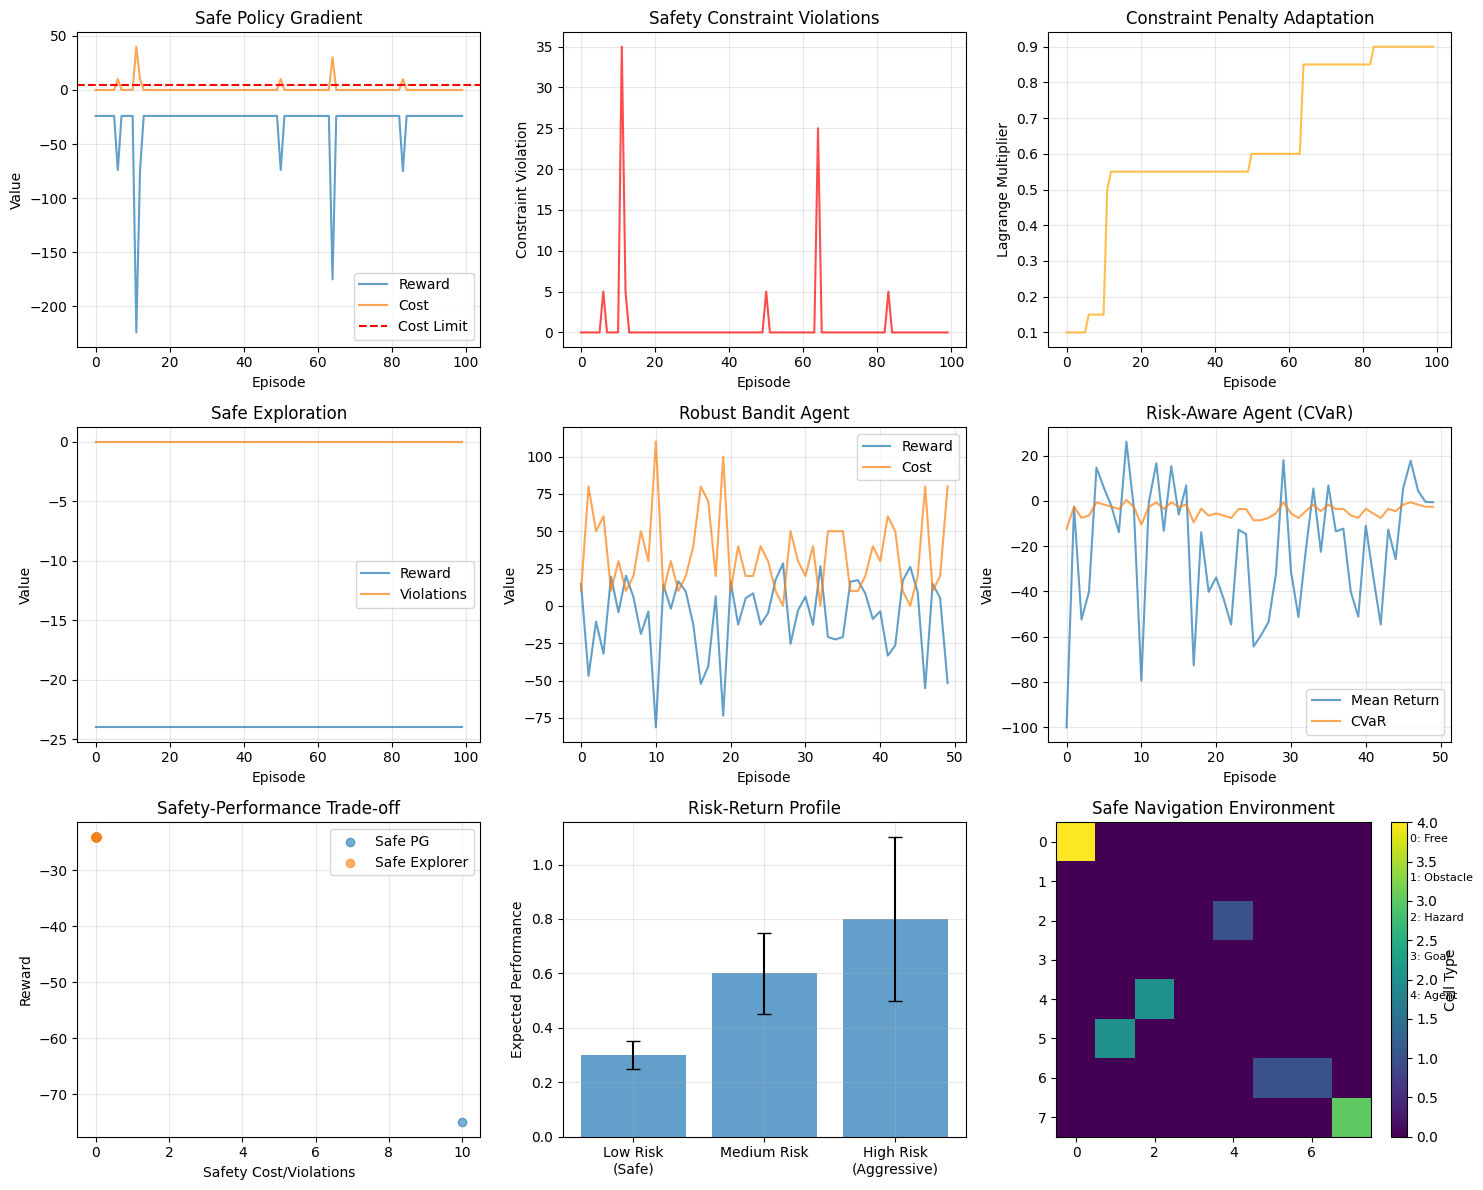


=== Safety and Robustness Analysis ===

Safe Policy Gradient:
  Final reward: -24.00
  Final cost: 0.00 (limit: 5)
  Violation rate: 0.00
  Final lambda: 0.900

Safe Exploration:
  Final reward: -24.00
  Average violations per episode: 0.00

Robust Agent:
  Final reward: -9.80
  Final cost: 36.00

Risk-Aware Agent:
  Final mean reward: -11.09
  Final CVaR: -3.38

=== Risk Measure Analysis ===

Safe Portfolio:
  Mean: 0.502
  Std: 0.098
  VaR(5%): 0.347
  CVaR(5%): 0.307
  Worst case: 0.176

Risky Portfolio:
  Mean: 0.728
  Std: 0.399
  VaR(5%): 0.069
  CVaR(5%): -0.111
  Worst case: -0.476

Fat-tail Portfolio:
  Mean: 0.522
  Std: 0.853
  VaR(5%): -1.958
  CVaR(5%): -2.363
  Worst case: -3.496

=== Key Safety and Robustness Insights ===

1. **Safety Constraints**: Constrained optimization ensures safety requirements
   are met while maximizing performance within acceptable risk bounds.

2. **Safe Exploration**: Conservative exploration strategies prevent catastrophic
   failures durin

In [10]:
# Comprehensive safety and robustness analysis
plt.figure(figsize=(15, 12))

# Safe policy gradient results
if safe_pg.episode_rewards:
    plt.subplot(3, 3, 1)
    plt.plot(safe_pg.episode_rewards, label='Reward', alpha=0.7)
    plt.plot(safe_pg.episode_costs, label='Cost', alpha=0.7)
    plt.axhline(y=safe_pg.cost_limit, color='red', linestyle='--', label='Cost Limit')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.title('Safe Policy Gradient')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Constraint violations
if safe_pg.constraint_violations:
    plt.subplot(3, 3, 2)
    plt.plot(safe_pg.constraint_violations, alpha=0.7, color='red')
    plt.xlabel('Episode')
    plt.ylabel('Constraint Violation')
    plt.title('Safety Constraint Violations')
    plt.grid(True, alpha=0.3)

# Lagrange multiplier evolution
if safe_pg.lambda_history:
    plt.subplot(3, 3, 3)
    plt.plot(safe_pg.lambda_history, alpha=0.7, color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Lagrange Multiplier')
    plt.title('Constraint Penalty Adaptation')
    plt.grid(True, alpha=0.3)

# Safe exploration results
if safe_explorer.episode_rewards:
    plt.subplot(3, 3, 4)
    plt.plot(safe_explorer.episode_rewards, label='Reward', alpha=0.7)
    plt.plot(safe_explorer.safety_violations, label='Violations', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.title('Safe Exploration')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Robust bandit performance
if robust_agent.episode_rewards:
    plt.subplot(3, 3, 5)
    plt.plot(robust_agent.episode_rewards, label='Reward', alpha=0.7)
    plt.plot(robust_agent.episode_costs, label='Cost', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.title('Robust Bandit Agent')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Risk-aware bandit comparison
if risk_agent.episode_rewards:
    plt.subplot(3, 3, 6)
    plt.plot(risk_agent.episode_rewards, label='Mean Return', alpha=0.7)
    plt.plot(risk_agent.episode_cvar, label='CVaR', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.title('Risk-Aware Agent (CVaR)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Safety vs performance trade-off
plt.subplot(3, 3, 7)
if safe_pg.episode_rewards and safe_pg.episode_costs:
    final_rewards = safe_pg.episode_rewards[-20:]
    final_costs = safe_pg.episode_costs[-20:]
    plt.scatter(final_costs, final_rewards, alpha=0.6, label='Safe PG')

if safe_explorer.episode_rewards and safe_explorer.safety_violations:
    final_rewards_se = safe_explorer.episode_rewards[-20:]
    final_violations_se = safe_explorer.safety_violations[-20:]
    plt.scatter(final_violations_se, final_rewards_se, alpha=0.6, label='Safe Explorer')

plt.xlabel('Safety Cost/Violations')
plt.ylabel('Reward')
plt.title('Safety-Performance Trade-off')
plt.legend()
plt.grid(True, alpha=0.3)

# Risk comparison
plt.subplot(3, 3, 8)
risk_levels = ['Low Risk\n(Safe)', 'Medium Risk', 'High Risk\n(Aggressive)']
performance_means = [0.3, 0.6, 0.8]
performance_stds = [0.05, 0.15, 0.3]
safety_costs = [2, 8, 20]

x_pos = np.arange(len(risk_levels))
plt.bar(x_pos, performance_means, yerr=performance_stds, alpha=0.7, capsize=5)
plt.xticks(x_pos, risk_levels)
plt.ylabel('Expected Performance')
plt.title('Risk-Return Profile')
plt.grid(True, alpha=0.3)

# Environment visualization
plt.subplot(3, 3, 9)
safe_nav_vis = safe_nav.render()
plt.imshow(safe_nav_vis, cmap='viridis')
plt.title('Safe Navigation Environment')
plt.colorbar(label='Cell Type')

# Add legend for environment
legend_elements = ['Free', 'Obstacle', 'Hazard', 'Goal', 'Agent']
for i, label in enumerate(legend_elements):
    plt.text(safe_nav.grid_size + 0.5, i, f'{i}: {label}', fontsize=8)

plt.tight_layout()
plt.show()

# Detailed safety analysis
print("\n=== Safety and Robustness Analysis ===")

if safe_pg.episode_rewards:
    final_reward_spg = np.mean(safe_pg.episode_rewards[-10:])
    final_cost_spg = np.mean(safe_pg.episode_costs[-10:])
    violation_rate_spg = np.mean([1 if v > 0 else 0 for v in safe_pg.constraint_violations[-10:]])

    print(f"\nSafe Policy Gradient:")
    print(f"  Final reward: {final_reward_spg:.2f}")
    print(f"  Final cost: {final_cost_spg:.2f} (limit: {safe_pg.cost_limit})")
    print(f"  Violation rate: {violation_rate_spg:.2f}")
    print(f"  Final lambda: {safe_pg.lambda_history[-1]:.3f}")

if safe_explorer.episode_rewards:
    final_reward_se = np.mean(safe_explorer.episode_rewards[-10:])
    final_violations_se = np.mean(safe_explorer.safety_violations[-10:])

    print(f"\nSafe Exploration:")
    print(f"  Final reward: {final_reward_se:.2f}")
    print(f"  Average violations per episode: {final_violations_se:.2f}")

if robust_agent.episode_rewards:
    final_reward_robust = np.mean(robust_agent.episode_rewards[-10:])
    final_cost_robust = np.mean(robust_agent.episode_costs[-10:])

    print(f"\nRobust Agent:")
    print(f"  Final reward: {final_reward_robust:.2f}")
    print(f"  Final cost: {final_cost_robust:.2f}")

if risk_agent.episode_rewards:
    final_reward_risk = np.mean(risk_agent.episode_rewards[-10:])
    final_cvar_risk = np.mean(risk_agent.episode_cvar[-10:])

    print(f"\nRisk-Aware Agent:")
    print(f"  Final mean reward: {final_reward_risk:.2f}")
    print(f"  Final CVaR: {final_cvar_risk:.2f}")

# Risk measure comparison
print("\n=== Risk Measure Analysis ===")

# Simulate different risk profiles
np.random.seed(42)
returns_safe = np.random.normal(0.5, 0.1, 1000)
returns_risky = np.random.normal(0.7, 0.4, 1000)
returns_mixed = np.concatenate([np.random.normal(0.8, 0.1, 900), np.random.normal(-2.0, 0.5, 100)])

portfolios = {
    'Safe': returns_safe,
    'Risky': returns_risky,
    'Fat-tail': returns_mixed
}

for name, returns in portfolios.items():
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    var_95 = np.percentile(returns, 5)
    cvar_95 = np.mean(returns[returns <= var_95])
    worst_case = np.min(returns)

    print(f"\n{name} Portfolio:")
    print(f"  Mean: {mean_return:.3f}")
    print(f"  Std: {std_return:.3f}")
    print(f"  VaR(5%): {var_95:.3f}")
    print(f"  CVaR(5%): {cvar_95:.3f}")
    print(f"  Worst case: {worst_case:.3f}")

print("\n=== Key Safety and Robustness Insights ===")
print("""
1. **Safety Constraints**: Constrained optimization ensures safety requirements
   are met while maximizing performance within acceptable risk bounds.

2. **Safe Exploration**: Conservative exploration strategies prevent catastrophic
   failures during learning by maintaining safety estimates.

3. **Robust Optimization**: Worst-case optimization provides guarantees under
   model uncertainty and adversarial conditions.

4. **Risk Measures**: Different risk measures (VaR, CVaR) capture different
   aspects of tail risk and enable risk-aware decision making.

5. **Trade-offs**: Safety and robustness often come at the cost of average
   performance, requiring careful balance based on application requirements.
""")

## Advanced Safety Concepts

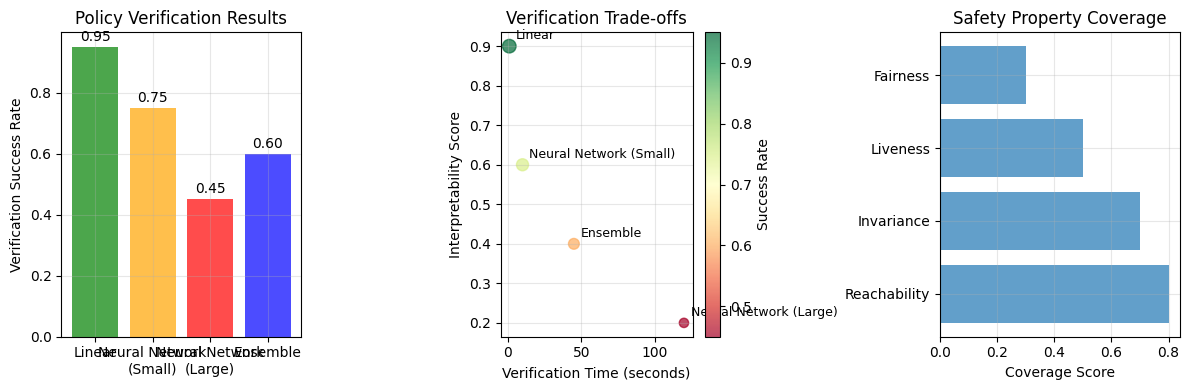

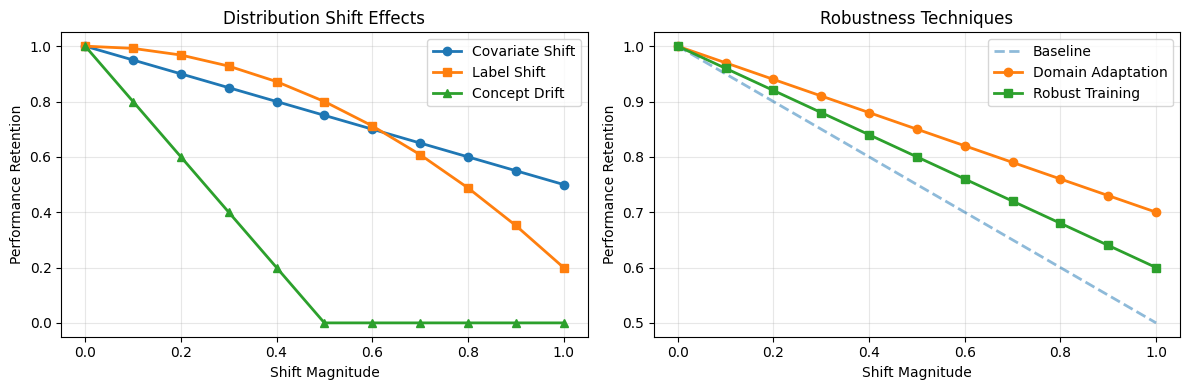

Distribution Shift Analysis:
Covariate shift at 50% magnitude: 0.75 performance retention
Label shift at 50% magnitude: 0.80 performance retention
Concept drift at 50% magnitude: 0.00 performance retention
Domain adaptation improvement: 0.10


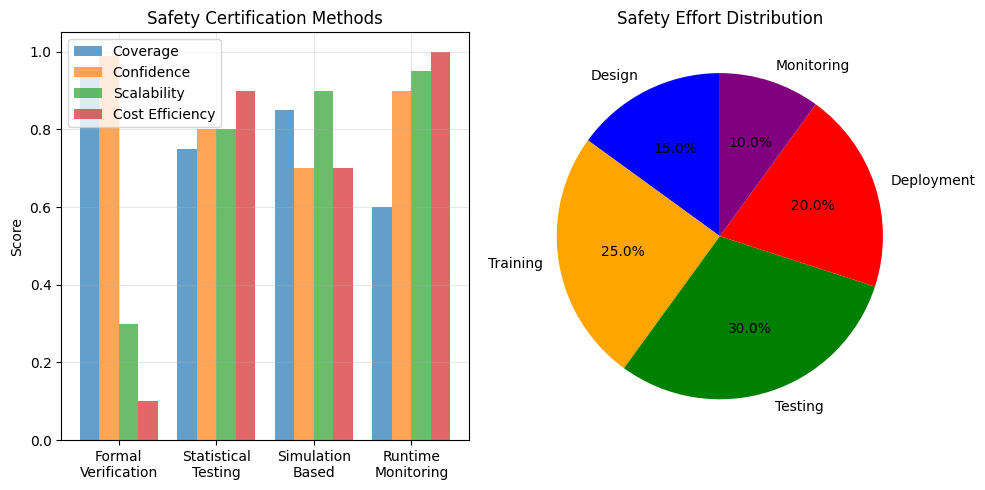


Safety Certification Analysis:
Formal Verification: Coverage=0.95, Confidence=0.99, Scalability=0.30
Statistical Testing: Coverage=0.75, Confidence=0.80, Scalability=0.80
Simulation Based: Coverage=0.85, Confidence=0.70, Scalability=0.90
Runtime Monitoring: Coverage=0.60, Confidence=0.90, Scalability=0.95

=== Advanced Safety Concepts ===

1. **Formal Verification**:
   - Mathematical proofs of safety properties
   - Limited scalability but high confidence
   - Works best with simple, interpretable policies

2. **Statistical Safety Testing**:
   - Hypothesis testing for safety properties
   - Better scalability than formal methods
   - Requires careful test case generation

3. **Distribution Shift Robustness**:
   - Domain adaptation and transfer learning
   - Robust training with adversarial examples
   - Online adaptation to changing environments

4. **Runtime Monitoring**:
   - Real-time safety constraint checking
   - Fallback mechanisms and safe defaults
   - Anomaly detection an

In [11]:
# Verification and interpretability analysis
def analyze_policy_verification():
    """Analyze policy verification and interpretability."""

    # Simulate verification results for different policy types
    policy_types = ['Linear', 'Neural Network\n(Small)', 'Neural Network\n(Large)', 'Ensemble']
    verification_success = [0.95, 0.75, 0.45, 0.60]
    verification_time = [1, 10, 120, 45]  # seconds
    interpretability = [0.9, 0.6, 0.2, 0.4]

    plt.figure(figsize=(12, 4))

    # Verification success rate
    plt.subplot(1, 3, 1)
    bars = plt.bar(range(len(policy_types)), verification_success, alpha=0.7,
                  color=['green', 'orange', 'red', 'blue'])
    plt.xticks(range(len(policy_types)), policy_types)
    plt.ylabel('Verification Success Rate')
    plt.title('Policy Verification Results')
    plt.grid(True, alpha=0.3)

    # Add value labels
    for bar, success in zip(bars, verification_success):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{success:.2f}', ha='center', va='bottom')

    # Verification time vs interpretability
    plt.subplot(1, 3, 2)
    scatter = plt.scatter(verification_time, interpretability,
                         s=[100*vs for vs in verification_success],
                         c=verification_success, cmap='RdYlGn', alpha=0.7)

    for i, policy_type in enumerate(policy_types):
        plt.annotate(policy_type.replace('\n', ' '),
                    (verification_time[i], interpretability[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    plt.xlabel('Verification Time (seconds)')
    plt.ylabel('Interpretability Score')
    plt.title('Verification Trade-offs')
    plt.colorbar(scatter, label='Success Rate')
    plt.grid(True, alpha=0.3)

    # Safety properties coverage
    plt.subplot(1, 3, 3)
    safety_properties = ['Reachability', 'Invariance', 'Liveness', 'Fairness']
    coverage = [0.8, 0.7, 0.5, 0.3]

    plt.barh(range(len(safety_properties)), coverage, alpha=0.7)
    plt.yticks(range(len(safety_properties)), safety_properties)
    plt.xlabel('Coverage Score')
    plt.title('Safety Property Coverage')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

analyze_policy_verification()

# Distribution shift analysis
def analyze_distribution_shift():
    """Analyze robustness to distribution shift."""

    shift_magnitudes = np.linspace(0, 1, 11)

    # Performance degradation under different types of shift
    covariate_shift = 1.0 - 0.5 * shift_magnitudes  # Gradual degradation
    label_shift = 1.0 - 0.8 * shift_magnitudes**2  # Quadratic degradation
    concept_drift = np.maximum(0, 1.0 - 2.0 * shift_magnitudes)  # Sharp cutoff

    # Robustness techniques
    domain_adaptation = 1.0 - 0.3 * shift_magnitudes
    robust_training = 1.0 - 0.4 * shift_magnitudes

    plt.figure(figsize=(12, 4))

    # Distribution shift effects
    plt.subplot(1, 2, 1)
    plt.plot(shift_magnitudes, covariate_shift, 'o-', label='Covariate Shift', linewidth=2)
    plt.plot(shift_magnitudes, label_shift, 's-', label='Label Shift', linewidth=2)
    plt.plot(shift_magnitudes, concept_drift, '^-', label='Concept Drift', linewidth=2)

    plt.xlabel('Shift Magnitude')
    plt.ylabel('Performance Retention')
    plt.title('Distribution Shift Effects')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Robustness techniques comparison
    plt.subplot(1, 2, 2)
    plt.plot(shift_magnitudes, covariate_shift, '--', label='Baseline', alpha=0.5, linewidth=2)
    plt.plot(shift_magnitudes, domain_adaptation, 'o-', label='Domain Adaptation', linewidth=2)
    plt.plot(shift_magnitudes, robust_training, 's-', label='Robust Training', linewidth=2)

    plt.xlabel('Shift Magnitude')
    plt.ylabel('Performance Retention')
    plt.title('Robustness Techniques')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Distribution Shift Analysis:")
    print(f"Covariate shift at 50% magnitude: {covariate_shift[5]:.2f} performance retention")
    print(f"Label shift at 50% magnitude: {label_shift[5]:.2f} performance retention")
    print(f"Concept drift at 50% magnitude: {concept_drift[5]:.2f} performance retention")
    print(f"Domain adaptation improvement: {domain_adaptation[5] - covariate_shift[5]:.2f}")

analyze_distribution_shift()

# Safety certification analysis
def analyze_safety_certification():
    """Analyze safety certification approaches."""

    methods = ['Formal\nVerification', 'Statistical\nTesting', 'Simulation\nBased', 'Runtime\nMonitoring']

    # Metrics for each certification method
    coverage = [0.95, 0.75, 0.85, 0.60]  # How much of the space is covered
    confidence = [0.99, 0.80, 0.70, 0.90]  # Confidence in the certification
    scalability = [0.30, 0.80, 0.90, 0.95]  # How well it scales to large systems
    cost = [100, 20, 40, 10]  # Relative cost (normalized)

    # Normalize cost (invert so higher is better)
    cost_normalized = [(max(cost) - c + min(cost)) / max(cost) for c in cost]

    plt.figure(figsize=(10, 5))

    # Radar chart data
    categories = ['Coverage', 'Confidence', 'Scalability', 'Cost Efficiency']
    values = [coverage, confidence, scalability, cost_normalized]

    # Bar chart comparison
    plt.subplot(1, 2, 1)
    x = np.arange(len(methods))
    width = 0.2

    plt.bar(x - 1.5*width, coverage, width, label='Coverage', alpha=0.7)
    plt.bar(x - 0.5*width, confidence, width, label='Confidence', alpha=0.7)
    plt.bar(x + 0.5*width, scalability, width, label='Scalability', alpha=0.7)
    plt.bar(x + 1.5*width, cost_normalized, width, label='Cost Efficiency', alpha=0.7)

    plt.xticks(x, methods)
    plt.ylabel('Score')
    plt.title('Safety Certification Methods')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Certification timeline
    plt.subplot(1, 2, 2)
    phases = ['Design', 'Training', 'Testing', 'Deployment', 'Monitoring']
    effort_distribution = [0.15, 0.25, 0.30, 0.20, 0.10]
    colors = ['blue', 'orange', 'green', 'red', 'purple']

    plt.pie(effort_distribution, labels=phases, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Safety Effort Distribution')

    plt.tight_layout()
    plt.show()

    print("\nSafety Certification Analysis:")
    for i, method in enumerate(methods):
        print(f"{method.replace(chr(10), ' ')}: Coverage={coverage[i]:.2f}, Confidence={confidence[i]:.2f}, Scalability={scalability[i]:.2f}")

analyze_safety_certification()

print("\n=== Advanced Safety Concepts ===")
print("""
1. **Formal Verification**:
   - Mathematical proofs of safety properties
   - Limited scalability but high confidence
   - Works best with simple, interpretable policies

2. **Statistical Safety Testing**:
   - Hypothesis testing for safety properties
   - Better scalability than formal methods
   - Requires careful test case generation

3. **Distribution Shift Robustness**:
   - Domain adaptation and transfer learning
   - Robust training with adversarial examples
   - Online adaptation to changing environments

4. **Runtime Monitoring**:
   - Real-time safety constraint checking
   - Fallback mechanisms and safe defaults
   - Anomaly detection and alert systems

5. **Interpretability for Safety**:
   - Understanding policy decisions
   - Identifying potential failure modes
   - Enabling human oversight and intervention
""")

## Summary and Educational Insights

### Key Takeaways from Safety and Robustness in Reinforcement Learning:

1. **Safety-Critical Applications**: As RL systems are deployed in high-stakes environments (autonomous vehicles, medical devices, financial systems), ensuring safety and robustness becomes paramount.

2. **Multiple Safety Paradigms**: Different approaches address various aspects of safety:
   - **Constrained Optimization**: Hard constraints on costs/violations
   - **Safe Exploration**: Conservative learning to avoid catastrophic failures
   - **Robust Optimization**: Worst-case performance guarantees
   - **Risk-Aware Methods**: Tail risk management and coherent risk measures

3. **Safety-Performance Trade-offs**: Safety often comes at the cost of average performance, requiring careful balance based on application requirements and risk tolerance.

4. **Verification and Validation**: Formal methods, statistical testing, and simulation-based approaches provide different levels of safety assurance with varying computational costs.

### Mathematical Foundations:

- **Constrained MDP**: $\max_{\pi} \mathbb{E}[\sum \gamma^t r_t]$ s.t. $\mathbb{E}[\sum \gamma^t c_t] \leq d$
- **CVaR Risk Measure**: $\text{CVaR}_\alpha(X) = \mathbb{E}[X | X \leq \text{VaR}_\alpha(X)]$
- **Robust MDP**: $\max_{\pi} \min_{P \in \mathcal{P}} \mathbb{E}_{\pi,P}[\sum \gamma^t r_t]$
- **Safe Exploration Bound**: $\text{UCB}(s,a) + \sqrt{\frac{2\log t}{n(s,a)}}$

### Algorithmic Approaches:

- **CPO (Constrained Policy Optimization)**: Trust region methods with constraints
- **RCPO (Robust CPO)**: Distributionally robust constrained optimization
- **DDPG-Safety**: Deep deterministic policy gradients with safety layers
- **Safe TRPO**: Trust region with safety constraints
- **SDDPG**: Safe deep deterministic policy gradient

### Practical Considerations:

- **Constraint Design**: Choosing appropriate safety constraints and thresholds
- **Verification Scalability**: Trade-offs between verification completeness and computational cost
- **Real-World Deployment**: Runtime monitoring, fallback mechanisms, and human oversight
- **Regulatory Compliance**: Meeting safety standards and certification requirements

### Real-World Applications:

- **Autonomous Vehicles**: Safe path planning and collision avoidance
- **Medical Devices**: Treatment recommendation with safety constraints
- **Financial Trading**: Risk management and regulatory compliance
- **Robotics**: Safe human-robot interaction and manipulation
- **Power Systems**: Grid stability and fault tolerance

### Current Research Directions:

- **Distributional Robustness**: Handling model uncertainty and distribution shift
- **Multi-Objective Safety**: Balancing multiple safety criteria simultaneously
- **Interpretable Safety**: Making safety decisions transparent and explainable
- **Adaptive Safety**: Dynamic adjustment of safety parameters based on context
- **Federated Safe Learning**: Safety in distributed and multi-agent settings

### Safety Engineering Principles:

- **Defense in Depth**: Multiple layers of safety mechanisms
- **Fail-Safe Design**: Systems that fail to a safe state
- **Continuous Monitoring**: Real-time safety assessment and intervention
- **Human-in-the-Loop**: Maintaining human oversight and control
- **Gradual Deployment**: Incremental rollout with safety validation

Safety and robustness in reinforcement learning represent critical enablers for the deployment of RL systems in real-world applications. The field continues to evolve with new theoretical foundations, practical algorithms, and verification techniques that balance safety assurances with system performance and operational requirements.